<a href="https://colab.research.google.com/github/muharremosmantopakkaya/LSTM-STOCK-PRICE-PREDICTION/blob/master/LSTM-STOCK-PRICE-PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### LSTM KULLANARAK HİSSE SENEDİ FİYAT TAHMİNİ

Bu uygulama, finansal veri analizi için Python'da LSTM (Uzun Kısa Vadeli Bellek) modelinin kullanımını göstermektedir. Veri indirme, model oluşturma ve tahminlerin görselleştirilmesi adımlarını içermektedir. LSTM modeli, bir hisse senedinin kapanış fiyatlarını tahmin etmek için kullanılmıştır. Kod blokları, hisse senedi verilerinin alınması, modelin eğitilmesi ve tahminlerin çizimlerle görselleştirilmesini içermektedir.

In [19]:
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import yfinance as yf

# Hisse senedi verisini alma

In [2]:
ticker = 'THYAO.IS'
start_date = '2015-01-01'
end_date = '2023-01-01'
stock_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed



# Kapanış fiyatlarını görselleştirme

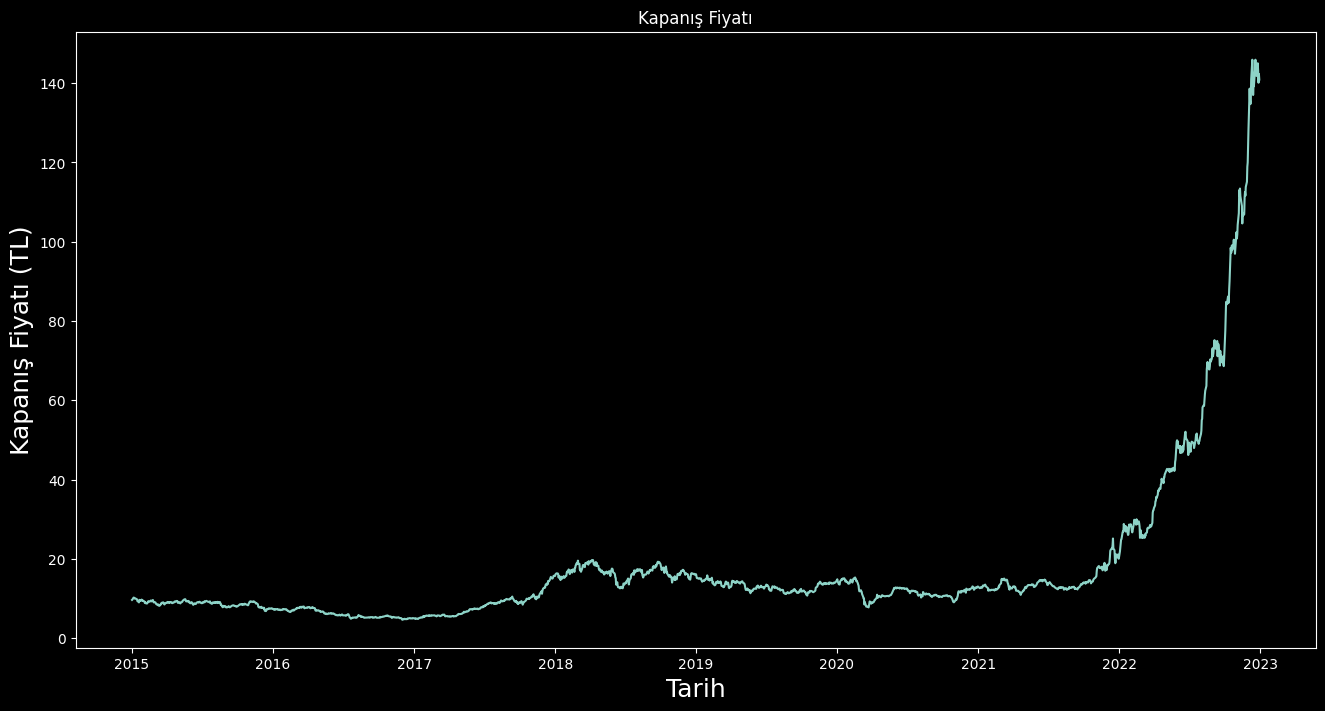

In [3]:
plt.style.use('dark_background')
plt.figure(figsize=(16, 8))
plt.title('Kapanış Fiyatı')
plt.plot(stock_data['Close'])
plt.xlabel('Tarih', fontsize=18)
plt.ylabel('Kapanış Fiyatı (TL)', fontsize=18)
plt.show()

# Veri hazırlama

In [4]:
data = stock_data.filter(['Close'])
dataset = data.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


# Eğitim veri uzunluğu

In [5]:
training_data_len = int(len(dataset) * 0.8)
train_data = scaled_data[:training_data_len, :]
test_data = scaled_data[training_data_len - 60:, :]


# Eğitim veri seti oluşturma


In [6]:
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


# LSTM modeli oluşturma ve eğitme


In [7]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=32, epochs=17)

Epoch 1/17
50/50 [==============================] - 9s 97ms/step - loss: 2.4571e-04
Epoch 2/17
50/50 [==============================] - 6s 111ms/step - loss: 3.3996e-05
Epoch 3/17
50/50 [==============================] - 4s 90ms/step - loss: 3.1770e-05
Epoch 4/17
50/50 [==============================] - 5s 108ms/step - loss: 3.0970e-05
Epoch 5/17
50/50 [==============================] - 5s 99ms/step - loss: 2.7664e-05
Epoch 6/17
50/50 [==============================] - 5s 93ms/step - loss: 2.4690e-05
Epoch 7/17
50/50 [==============================] - 6s 117ms/step - loss: 2.4887e-05
Epoch 8/17
50/50 [==============================] - 5s 90ms/step - loss: 2.1723e-05
Epoch 9/17
50/50 [==============================] - 4s 89ms/step - loss: 2.2429e-05
Epoch 10/17
50/50 [==============================] - 6s 118ms/step - loss: 2.1986e-05
Epoch 11/17
50/50 [==============================] - 4s 90ms/step - loss: 2.0883e-05
Epoch 12/17
50/50 [==============================] - 5s 93ms/step - lo

# Modelin test edilmesi


In [8]:
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

13/13 [==============================] - 1s 40ms/step


# Grafik çizimi

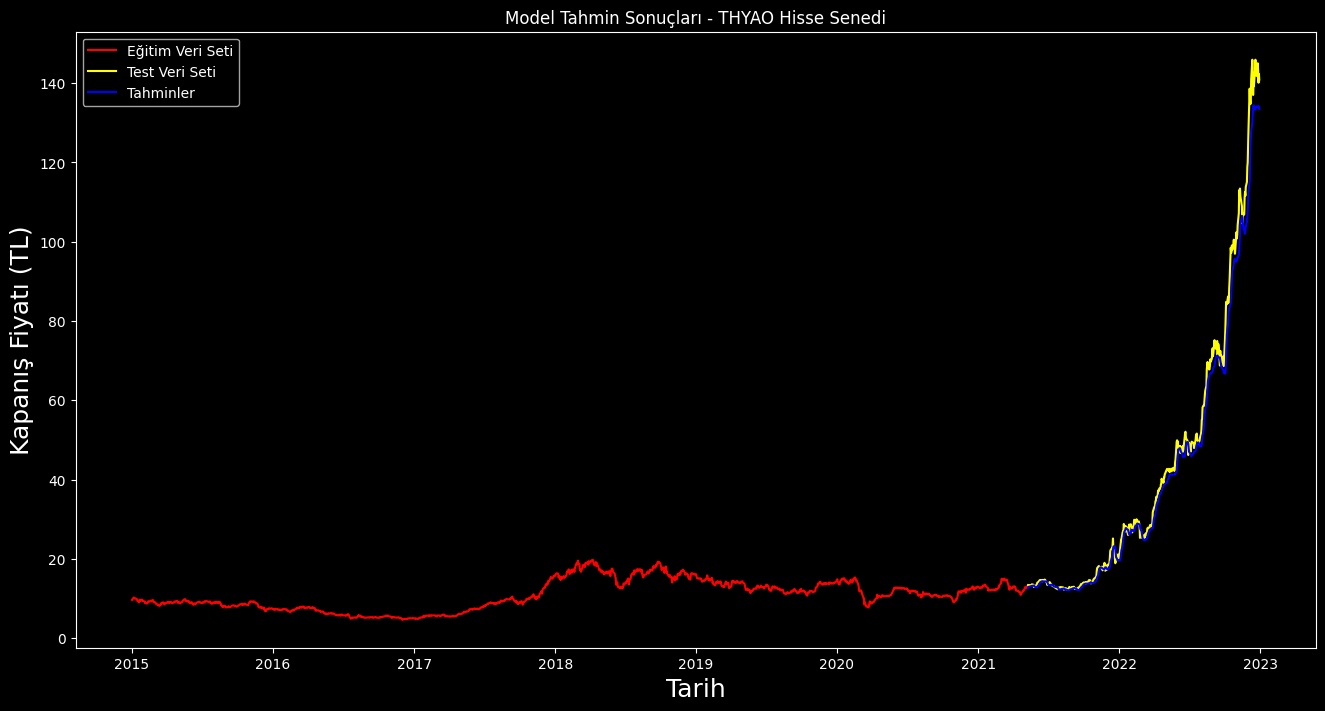

In [25]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model Tahmin Sonuçları - THYAO Hisse Senedi')
plt.xlabel('Tarih', fontsize=18)
plt.ylabel('Kapanış Fiyatı (TL)', fontsize=18)

plt.plot(train['Close'], color='red', label='Eğitim Veri Seti')
plt.plot(valid['Close'], color='yellow', label='Test Veri Seti')
plt.plot(valid['predictions'], color='blue', label='Tahminler')

plt.legend(loc='upper left')  # Legend konumunu değiştirilebilir

plt.show()

# Grafik çizimi

In [14]:

train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid['predictions'] = predictions

# Son 15 günü görüntüleme

In [15]:
print(valid.tail(15))

                 Close  predictions
Date                               
2022-12-12  145.899994   129.932571
2022-12-13  144.000000   132.298065
2022-12-14  137.000000   134.183395
2022-12-15  140.100006   134.404266
2022-12-16  139.199997   134.137192
2022-12-19  143.300003   133.480362
2022-12-20  145.899994   133.315857
2022-12-21  142.899994   133.814346
2022-12-22  142.100006   134.112228
2022-12-23  141.800003   134.122238
2022-12-26  145.000000   133.925232
2022-12-27  143.100006   134.134399
2022-12-28  140.100006   134.235229
2022-12-29  142.300003   133.802399
2022-12-30  140.899994   133.490997


# İleriye dönük 1 ay için fiyat tahmini yapma

In [16]:
last_60_days = scaled_data[-60:]
X_test = np.array([last_60_days])
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price_1months = model.predict(X_test)
pred_price_1months = scaler.inverse_transform(pred_price_1months)
print(f'{ticker} için 1 ay sonraki fiyat: {pred_price_1months[0][0]}')

1/1 [==============================] - 0s 41ms/step
THYAO.IS için 1 ay sonraki fiyat: 133.0821075439453
